# 目标检测算法:R-CNN, SSD, YOLO

R-CNN
- 使用启发式搜索算法来选择锚框
- 使用预训练模型来对每个锚框抽取特征
- 训练一个SVM来对类别分类
- 训练一个线性回归模型来预测边缘框偏移

兴趣区域(RoI)池化层
- 给定一个锚框，均匀分割成n*m块，输出每块里的最大值
- 不管锚框多大，总是输出nm个值

Fast RCNN
- 使用CNN对图片抽取特征
- 使用RoI池化层对每个锚框生成固定长度特征

Faster R-CNN
- 使用一个区域提议网络来替代启发式搜索来获得更好的锚框

MASK R-CNN
- 如果有像素级别的标号，使用FCN来利用这些信息

总结
- R-CNN是最早、也是最有名的一类基于锚框和CNN的目标检测算法
- Fast/Faster R-CNN继续提升性能
- Faster R-CNN 和 MASK R-CNN是在最高要求的精度场景下使用

## 单发多框检测(SSD)

生成锚框
- 对每个像素，生成多个以它为中心的锚框


SSD模型
- 一个基础网络来抽取特征，然后多个卷积层来减半高宽
- 在每段都生成锚框
  - 底部段来拟合小物体，顶部段来拟合大物体
- 对每个锚框预测类别和边缘框

总结
- SSD通过单神经网络来检测模型
- 以每个像素为中心的产生多个锚框
- 在多个段的输出上进行多尺度检测

YOLO(你只看一次)
- SSD锚框大量重叠，因此浪费了很多计算
- YOLO将图片均匀分成S✖S个锚框
- 每个锚框预测B个边缘框
- 后续版本(V2、V3、V4)有持续改进

## 多尺度检测

In [1]:
#导入第三方库
%matplotlib inline
import torch
from d2l import torch as d2l
import os, torchvision
import pandas as pd
from torch.nn import functional as F
from torch import nn

In [2]:
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

In [3]:
#在特征图上生成锚框，对应的图像上进行均匀采样的锚框绘制
def display_anchors(fmap_w, fmap_h, s):
    """在特征图上绘制锚框"""
    d2l.set_figsize()
    #定义特征图，前两位的输入不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    #生成锚框
    anchors = d2l.multibox_prior(fmap, sizes= s, ratios= [1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0] * bbox_scale)

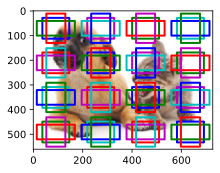

In [4]:
#锚框尺度选为0.15
display_anchors(fmap_w= 4, fmap_h= 4, s=[0.15])

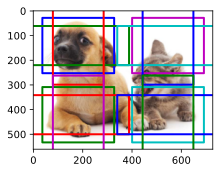

In [5]:
#将特征图的高宽减少一半，锚框尺度增加到0.4
display_anchors(fmap_w= 2, fmap_h= 2, s=[0.4])

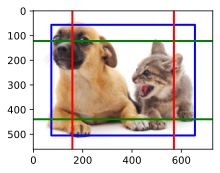

In [6]:
#继续将特征图的高宽减少一半，锚框尺度增加到0.8，锚框中心变为图像中心
display_anchors(fmap_w= 1, fmap_h= 1, s= [0.8])

## 目标检测数据集

In [12]:
#下载并读取数据集
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip', 
                                    '5de26c8fce5ccdea9f91267273464dc968d20d72')

def read_data_bananas(is_train= True):
    """读取香蕉数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir, 'bananas_train' 
                      if is_train else 'bananas_val', 'images', f'{img_name}')))
        #target包含5个元素(类别，左上角x，左上角y，右下角x，右下角y)
        #其中所有图像都具有相同的香蕉类
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [8]:
#创建一个自定义Dataset实例来加载香蕉测试数据集
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read' + str(len(self.features)) + (f' training examples' if is_train 
              else f'validation examples'))
    
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [13]:
#为训练集和测试集返回两个数据加载器实例
def load_data_bananas(batch_size):
    """返回香蕉检测数据集的加载器实例(训练和测试)"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train= True), batch_size= batch_size, shuffle= True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train= False), batch_size= batch_size, shuffle= False)
    return train_iter, val_iter

In [14]:
batch_size, egde_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
#取出一个批量的数据进行查看
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read1000 training examples
read100validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

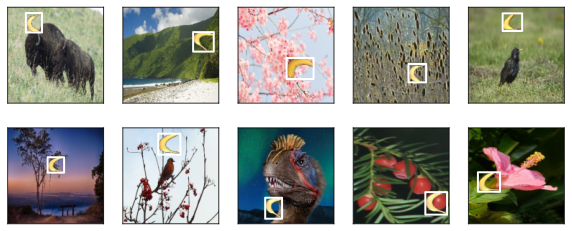

In [18]:
#展示带有真实边界框的图像
#展示图象时将四维信息拉伸到二维，将channel维放到第4维进行拉伸
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale= 2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * egde_size], colors= ['w'])

## 单发检测框(SSD)

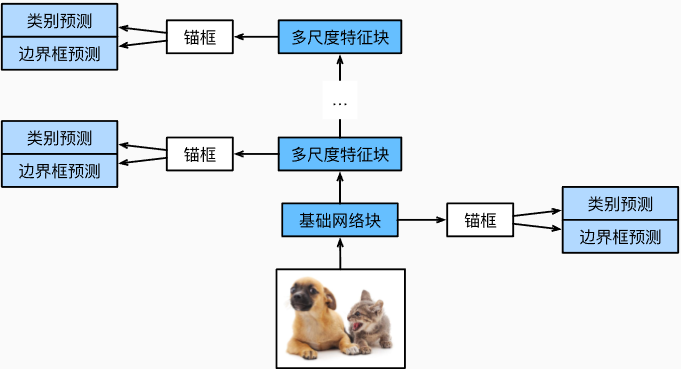

In [2]:
#类别预测层
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors* (num_classes + 1), 
                     kernel_size= 3, padding= 1)
#边界框预测层
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size= 3, padding= 1)

In [3]:
#连接多尺度的预测
#为同一个小批量构建两个不同比例的特征图(Y1和Y2)
def forward(x, block):
    return block(x)
#输出形状为(批量大小，通道数，高度，宽度)
Y1 = forward(torch.zeros(2, 8, 20, 20), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros(2, 16, 10, 10), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [4]:
#为了提高计算效率，统一输出尺寸，将张量转换为(批量大小，高✖宽✖通道数)的二维形状
#通道维包含了中心相同锚框的预测结果，将通道维移到最后一维来保留信息
def flatten_pred(pred):
    """改变锚框预测结果的输出形状"""
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim= 1)

def concat_preds(preds):
    """连结不同通道信息"""
    return torch.cat([flatten_pred(p) for p in preds], dim= 1)

In [5]:
#实现连接预测输出
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [6]:
#高和宽减半块
def down_sample_blk(in_channels, out_channels):
    """定义高宽减半块"""
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, 
                             kernel_size= 3, padding= 1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [7]:
#通过高宽减半块更改输入通道的数量并将输入图的高宽减半
forward(torch.zeros((2, 3, 20 ,20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [8]:
#基本网络块
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [9]:
#实现完整的模型
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [10]:
#对每一块定义前向传播
#输出包括：CNN特征图Y、当前尺度下根据Y生成的锚框、预测的锚框类别和偏移量(基于Y)
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [12]:
#定义TinySSD模型实例
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            #赋予对象属性
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], 
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))
        
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            #通过getattr访问每一层
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X,
                getattr(self, f'blk_{i}'), sizes[i], ratios[i], 
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim= 1)
        cls_preds = concat_preds(cls_preds)
        #更改类别预测形状，预测类别数包括背景类别，所以加1
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [13]:
net = TinySSD(num_classes= 1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)
print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [14]:
#训练模型
#读取数据集并初始化训练器
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [15]:
#初始化网络，香蕉为1个类别
device, net = d2l.try_gpu(), TinySSD(num_classes= 1)
trainer = torch.optim.SGD(net.parameters(), lr= 0.2, weight_decay= 5e-4)

In [16]:
#定义损失函数和评价函数
#两类损失：锚框损失和正类锚框偏移量损失
#bbox_masks是一个掩码变量，让负类锚框和填充锚框不参与损失计算
cls_loss = nn.CrossEntropyLoss(reduction= 'none')
bbox_loss = nn.L1Loss(reduction= 'none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    """计算模型损失，包含两部分：1、锚框损失 2、正类锚框偏移量损失"""
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), 
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim= 1)
    bbox = bbox_loss(bbox_preds * bbox_masks, 
                     bbox_labels * bbox_masks).mean(dim= 1)
    return cls + bbox

In [17]:
#使用平均绝对误差来评价边界框的预测结果
def cls_eval(cls_preds, cls_labels):
    """评价分类损失"""
    return float((cls_preds.argmax(dim= -1).type(
                  cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.24e-03, bbox mae 3.13e-03
9879.1 examples/sec on cuda:0


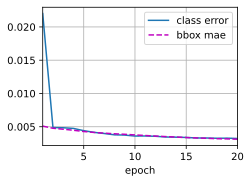

In [22]:
#进行模型训练
#在前向传播过程中生成多尺度锚框,并预测其cls_preds和bbox_preds
#根据标签信息Y生成锚框标记类别cls_labels和偏移量bbox_labels
#最后，依据类别和偏移量的预测和标注值计算损失函数
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel= 'epoch', xlim=[1, num_epochs], 
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        #清空梯度
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        #生成多尺度锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        #为每个锚框生成预测类别
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        #根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, 
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2]/ metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on ' f'{str(device)}')

In [23]:
#预测目标
X = torchvision.io.read_image('../data/banana-detection/bananas_train/images/0.png').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [24]:
#使用multibox_detection函数，根据锚框及其预测偏移量得到预测边界框
#然后，通过非极大值抑制来移除相似的预测边界框
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim= 2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    #对正类锚框创建索引
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

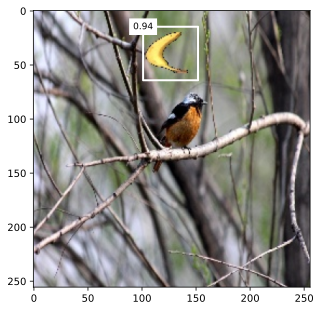

In [25]:
#筛选置信度不低于0.9的边界框作为最终输出
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        #获取边界框坐标
        bbox = [row[2:6] *torch.tensor((w, h, w, h), device= row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')
display(img, output.cpu(), threshold= 0.9)